<a href="https://colab.research.google.com/github/igrodfer/DeepLearningLab/blob/main/cifar10_8862.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.datasets import cifar10
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Add
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import Input, Model
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

In [2]:
batch_size = 100
num_classes = 10
epochs = 200

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2)

In [5]:
def resblock(x, filters,ds=False):
  fx = Conv2D(filters, (3,3), strides=(1 if not ds else 2), padding='same')(x)
  fx = BN()(fx)
  fx = GN(0.3)(fx)
  fx = Activation('relu')(fx)

  fx = Conv2D(filters, (3,3), padding='same')(fx)

  if ds:
    x = Conv2D(filters, (1,1),strides=2, padding='same')(x)

  out = Add()([x,fx])

  fx = BN()(fx)
  fx = GN(0.3)(fx)
  out = Activation('relu')(fx)

  return out

In [6]:
def CBGN(x,filters,ishape=0):
  if (ishape!=0):
    fx = Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape)(x)
  else:
    fx = Conv2D(filters, (3, 3), padding='same')(x)
  
  fx = BN()(fx)
  fx = GN(0.3)(fx)
  fx = Activation('relu')(fx)
  fx = MaxPooling2D(pool_size=(2, 2))(fx)
  
  return fx

In [7]:
input = Input(shape=x_train.shape[1:])

out = CBGN(input,32)
out = resblock(out,32)
out = resblock(out,32)

out = resblock(out,64,True)
out = resblock(out,64)
out = resblock(out,64)

out = resblock(out,128,True)
out = resblock(out,128)
out = resblock(out,128)

out = resblock(out,256,True)
out = resblock(out,256)
#out = resblock(out,256)

#out = resblock(out,512,True)
#out = resblock(out,512)

out = Flatten()(out)
out = Dense(512)(out)
out = BN()(out)
out = GN(0.3)(out)
out = Activation('relu')(out)

out = Flatten()(out)
out = Dense(num_classes)(out)
out = Activation('softmax')(out)

model = Model(input,out)

In [ ]:
model.summary()

In [8]:

## OPTIM AND COMPILE
opt = SGD(learning_rate=0.01, decay=1e-6,momentum=0.9)
opt = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [9]:

history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)

## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/200
500/500 [==============================] - 47s 75ms/step - loss: 1.9679 - accuracy: 0.2470 - val_loss: 2.9331 - val_accuracy: 0.2580
Epoch 2/200
500/500 [==============================] - 37s 74ms/step - loss: 1.6906 - accuracy: 0.3659 - val_loss: 2.0461 - val_accuracy: 0.3652
Epoch 3/200
500/500 [==============================] - 35s 70ms/step - loss: 1.5365 - accuracy: 0.4362 - val_loss: 2.1171 - val_accuracy: 0.4349
Epoch 4/200
500/500 [==============================] - 35s 71ms/step - loss: 1.4247 - accuracy: 0.4820 - val_loss: 2.8961 - val_accuracy: 0.4255
Epoch 5/200
500/500 [==============================] - 35s 70ms/step - loss: 1.3405 - accuracy: 0.5185 - val_loss: 2.5397 - val_accuracy: 0.4310
Epoch 6/200
500/500 [==============================] - 35s 71ms/step - loss: 1.2784 - accuracy: 0.5451 - val_loss: 2.8737 - val_accuracy: 0.3865
Epoch 7/200
500/500 [==============================] - 36s 72ms/step - loss: 1.2163 - accuracy: 0.5689 - val_loss: 3.1327 - val_ac

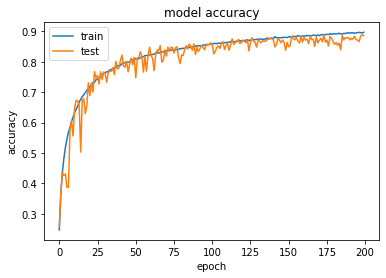

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()